In [1]:
import numpy as np
dt = 1.0/30
g = 9.8
L = 0.4

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

What is a LQR (Linear Quadratic Regulator?
Basically the only math that mankind can rip to shreds is linear algebra (matrix shit). We can solve Matrix equations (and by that I mean we can get computers to solve) like nobodies business.
Hence it often behooves us to find a way to formulate any problem in engineering or physics in some kind of linear framework.
Optimizing quadratic functions leads to a linear problem because the derivative of a quadratic term is a linear term.
So the LQR is a formulation of a control problem that uses a quadratic cost function and evolves under linear dynamics.
The formulation of a control problem is one in which we are trying a cost function C(x,u) that may be a sum over many time steps, where x is the state vector (may an often will include velocities. Anything we need to be able to predict the next state) and u is the control vector (some set of numbers we get to decide like voltage to a motor or something)
It just so happens that this combo is exactly solvable in terms of matrix operations.

Let's define $z=(x,u)$ as a vector that is made out of stacked state and action vectors (the direct sum of their spaces)
Now, one way of solving the problem would be to make just one big matrix with a dimensionality proprtional to the number of time steps we're looking ahead, and maybe in fact that is smart since python is slow and putting everything into numpy might be both easier to program and faster. The constraint that the steps are connected by the dynamics can be implemented by adding in lagrange multipliers at every time step. This still maintains the quadratic nature of the minimization.
$\min \sum_{t=0}^{N-1} (z^{T}Cz + c^{T}z) +\sum_{t=0}^{N-2} \lambda_t^{T} (Az_{t}-z_{t+1})$
But let's take a different approach
It is very interesting that there is a method to solve this problem that mirrors the methodology of reinforcement learning.
If we had a way of evaluating the value of being in a state, we should just take the action that puts us in the highest valued state.
That requires lookahead though. We need to know what state our actions take us to.
Hence there is a clever trick, the Q function. The Q function takes the current state and an action as parameters and outputs the expected return of that combo. With this, we don't need to lookahead using dynamics in order to figure out which is the best action, we can just search the different actions.

In the LQR, the V and Q functions are quadratic. This means they can be parametrized by a Matrix term and a vector term $Q(x,a)=z^{T} Q z + q^{T} z $

The solution starts as the end. At the end we already know the Q function. It is just the cost function, since there is no future cost to consider.
We can minimize with respect to the control u to get the value function V. The solution to this minimaztion is a way to write the control in terms of x, giving us a control matrix K. $u_t=Kx_t+k$ Substituing this expession into the Q expression removes the variable u, giving us the value function V. Then we can backup one step using the dynamics to get the previous Q function in terms of the current V function.

What is in particular good about this method is the sequence of K matrices we get, which are useful for a feedback system.

Now many systems are in fact not quadratic cost or linear dynamics. Nevertheless we can leverage our abilities to make an iterative solver for a linearization of the nonlinear stuff.
The mapping from the nonlinear problem is a touch confusing because the new variables x' and u' are the displacement from the current estimated trajectory, not the entire trajectory itself. First, this means the dynamics f vector is going to be zero since a zero displacement should evolve into a zero dispacelemtn. The c vector is also no longer the original. It is the gradient of cost function and in general will be a function of the actual path x,u. 

It's a way of solving 

https://studywolf.wordpress.com/2016/02/03/the-iterative-linear-quadratic-regulator-method/


So we are following the conventions setup in
https://katefvision.github.io/katefSlides/RECITATIONtrajectoryoptimization_katef.pdf


The block functions allow you to get subblocks of matrices
forward computes N steps forward
backward performs LQR
iLQR does iterative forward and backward passes to try to hone in on an optimal solution

It is important to note that the backward pass is done on the linearized dynamics of $\delta x = x-x_0 $. where $x_0$ is the actual path evaluted in the forward pass. 

I used split step integration (called Verlet or leapfrog) where I alternate updating the velocity and position. This scheme tends to be more stable and more energy conserving. When I updated them together at first using a straightforward euler step, the energy in the pendulum exploded. Ruh Roh. Unfortunately the way I did this makes every two steps correspond to a single time step.


We're using cartpole as an example since the whole reason this code was written was to control a cartpole.

The equations of motion for a cartpole are
$\frac{d^2\theta}{dt^2}=\frac{3}{2L}(a \sin(\theta)-g\cos(\theta))$
I got this out of a Lagrangian. Don't worry about it. The point is by accelerating the cart an amount a, you can apply a torque to the pole. The $\sin$ factor means you get no torque if the pole is horizontal and maximum torque if the pole is vertical. The standing upright position is the place where g has the least effect and a has the most effect, which is nice.
The linearization around this path is given by
$\frac{d^2\delta\theta}{dt^2}=\frac{3}{2L}(a \delta\theta\cos(\theta)+\delta a \sin(\theta) +g\delta\theta\sin(\theta))$

We add a touch of weight to C for 

To make C mostly have comparable units we add factors corresponding to the important physical scales. $\sqrt(L/g)$ is the time it takes for a small perturbation from equilibrium to roughly double. $g$ is the gravitational acceleration that any cart acceleration is going to be compared to.

There is almost certainly something to using ODEint rather than my own custom rolled integration routine. But then I can't use odeint for the backwards pass unless I used a finite difference.




In [3]:
def F(theta,a, t):
    if t%2 == 0:
        return np.array([[1,dt,0],
                     [0, 1, 0]])
    else:
        return np.array([[1,0,0],
                     [ 3/2/L * (a * np.cos(theta[0]) + g * np.sin(theta[0])) * dt, 1,
                     (3 / 2 * np.sin(theta[0]) / L ) * dt]])

def step(theta, a, t):
    if t%2==0:
        theta1 = theta[0] + theta[1]*dt 
        dtheta = theta[1]
    else:
        theta1 = theta[0]    
        dtheta = theta[1] +  3/2/L * (a * np.sin(theta1) - g * np.cos(theta1)) * dt
    return np.array( [theta1,dtheta])
def f(xu):
    return np.zeros(2)#step(xBlock(xu), uBlock(xu))

def cost(theta):
    return (theta[0]-np.pi/2)**2

def C():
    return np.array([[1,0,0],
                     [0,0.01 * np.sqrt(L/g),0],
                     [0,0,0.01 / g]])
def c(theta,a):
    return C() @ np.array([theta[0] - 1 * np.pi/2, theta[1], a])

def xxBlock(R):
    return R[0:2,0:2]
def xuBlock(R):
    return R[0:2,2].reshape((2,1))
def uxBlock(R):
    return R[2,0:2].reshape((1,2))
def uuBlock(R):
    return R[2,2].reshape((1,1))
def Block(xx,xu,ux,uu):
    return np.block([[xx,xu],[ux,uu]])
    R = np.zeros((3,3))
    R[2,2] = uu
    R[2,0:2] = ux
    R[0:2,2] = xu
    R[0:2,0:2] = xx
    return R
def xBlock(v):
    return v[0:2]
def uBlock(v):
    return v[2].reshape((1))
def Stack(x,u):
    v = np.zeros(3)
    v[:2] = x
    v[2] = u
    return v 
    

In [4]:
N = 60 #lookahead

#thetas hold time 0...N
#ass hold time 0...N
def forward(theta0, Ks, ks, thetas0, ass0, N):
    thetas = []
    ass = []
    thetas.append(theta0)
    theta = np.copy(theta0)
    for i in range(N):
        a = ass0[i] + Ks[i]@(theta-thetas0[i]) + ks[i]
        theta = step(theta, a, i)
        thetas.append(theta)
        ass.append(a)
    a = ass0[i] + Ks[i]@(theta-thetas0[i]) + ks[i]
    ass.append(a)
    return thetas, ass

def backward(thetas, ass0, N):
    #This is a transcription of the Stanford slides basically.
    Q =  C() #For the final step t=N, The Q matrix is just the Cost Matrix
    q = c(thetas[-1],ass0[-1]) #likewise
    K = - np.linalg.inv(uuBlock(Q)) @ uxBlock(Q)
    k = - np.linalg.inv(uuBlock(Q)) @ uBlock(q)
    V = xxBlock(Q) + xuBlock(Q) @ K + K.T @ uxBlock(Q) + K.T @ uuBlock(Q) @ K
    v = xBlock(q) + xuBlock(Q) @ k + K.T @ uBlock(q) + K.T @ uuBlock(Q) @ k
    Ks = [] #We'll collect up and store the control matrices (matrices that give good linear feedback), u=Kx+k
    ks = [] 
    for i in reversed(range(N)): # counts time N-1 down to 0
        Ft = F(thetas[i],ass0[i],i) #Dynamics matrix x_{t+1} = F @ (x_t,u_t) + f
        ft = np.zeros(2) #step(thetas[i], ass0[i])
        #print(ft)
        Q = C() + Ft.T @ V @ Ft # comes from C + x_t+1 @ V @x_t+1, 
        q = c(thetas[i],ass0[i]) + Ft.T @ V @ ft + Ft.T @ v
        #print(Q)
        #print(uuBlock(Q))
        K = - np.linalg.inv(uuBlock(Q)) @ uxBlock(Q) #minimizing over u.
        k = - np.linalg.inv(uuBlock(Q)) @ uBlock(q)
        V = xxBlock(Q) + xuBlock(Q) @ K + K.T @ uxBlock(Q) + K.T @ uuBlock(Q) @ K #substituting u = Kx+k into Q
        v = xBlock(q) + xuBlock(Q) @ k + K.T @ uBlock(q) + K.T @ uuBlock(Q) @ k
        Ks.append(K)
        ks.append(k)
    return list(reversed(Ks)), list(reversed(ks))

def iLQR(theta0, iters=30, N=20, Ks=None, ks=None):
    if not Ks:
        Ks = np.zeros((N,1,2))
    if not ks:
        ks = np.zeros((N,1))
    ass = np.zeros(N)
    thetas=np.zeros((N,2))
    for i in range(iters):
        thetas, ass = forward(theta0, Ks, ks, thetas, ass, N)
        assert len(thetas) == len(ass)
        
        Ks, ks = backward(thetas, ass, N)
    return thetas, ass, Ks, ks
    

        

If we set the pendulum at the (unstable) equilibrium position, it should not requitr much intervention. Sanity check.

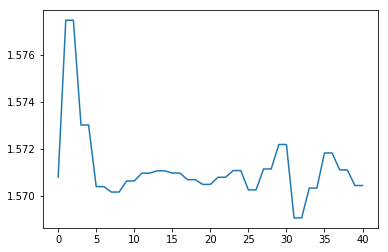

In [35]:
N=40
thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2,0.2]), iters=10000)
plt.plot(np.array(thetas)[:,0])
#print(thetas)

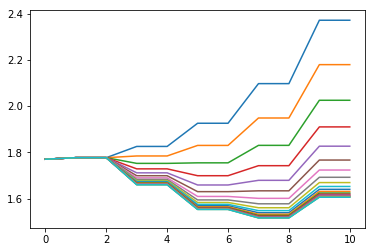

In [102]:
#Deomnstrating the convergence properties in terms of iLQR iterations
for i in range(20):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=10*i+1,N=10)
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

Uncontrolled evolution

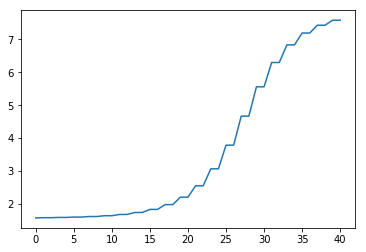

In [78]:
N=40
theta0 = np.array([np.pi/2,0.2])
Ks = np.zeros((N,1,2))
ks = np.zeros((N,1))
ass = np.zeros(N)
thetas=np.zeros((N,2))
thetas, ass = forward(theta0, Ks, ks, thetas, ass)
plt.plot(np.array(thetas)[:,0])

It is controlling it. Numerical instability of my integrator seems to be a problem. Also too long a horizon seems to kill it. Maybe this is because My initilized system to no control at all. Possibility: Do iterative deepdning of hirzon to get good initial control. Or set to reasonable PID. Set control to final Ks k value or middle vlaue or just zeros.
Hmmm seems to do decreasing control for later time.
Just the final step seems to make a huge effect.

Hmm. The crossing of N to being a big problem seems to be when we transition to radically different dynamics.

The value of K found is -84, which is similar to the -54 required to be remotely stable at all. But then this number is decreasing towards the end of the episode.

With my splitting of the timestep, the transition to iLQR no longer being convergent is at ~.5 seconds. This is not far off from the camera letcy time.

It also suggests that the linear control that is ok for near equlibrium will not be acceptable for the amount of disequlibirum that may exist after 5 frames



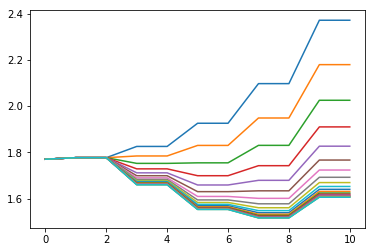

In [103]:
#Deomnstrating the convergence properties in terms of iLQR iterations
for i in range(20):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=10*i+1,N=10)
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

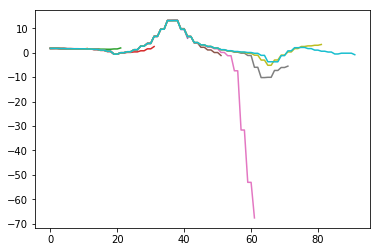

In [105]:
#Deomnstrating the convergence properties in terms of lookahead
for i in range(10):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=200,N=10*i+1)
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

Interesting Hump there around 30. Could it be that it is worth it to allow the thing to naturally return to it's original position under it's own dynamics? Kind of makes sense. Even though I made the cost of force low, I never considered the relative scales. Or it could be getting stuck in a local minimum.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in add


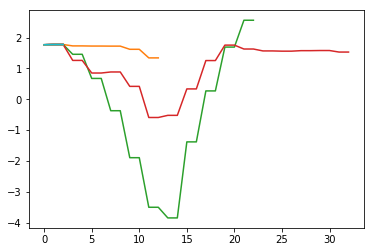

In [118]:
#Deomnstrating the convergence properties in terms of lookahead
thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=200,N=2)
for i in range(10):
    thetas, ass, Ks, ks = iLQR(np.array([np.pi/2+0.2,0.2]), iters=200,N=10*i+2, Ks=Ks, ks=ks)
    for j in range(10):
        Ks.append(Ks[-2])
        ks.append(ks[-2])
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

[array([[ 0.,  0.]]), array([[-91.58270116,  -5.97203775]]), array([[ 0.,  0.]]), array([[-65.39079586,  -5.11826558]]), array([[ 0.,  0.]]), array([[-51.94929083,  -4.63588524]]), array([[ 0.,  0.]]), array([[-44.93861249,  -4.37393346]]), array([[ 0.,  0.]]), array([[-41.68407114,  -4.23600278]]), array([[ 0.,  0.]]), array([[-40.60067475,  -4.16690194]]), array([[ 0.,  0.]]), array([[-40.5458947 ,  -4.13507703]]), array([[ 0.,  0.]]), array([[-40.80364513,  -4.1219448 ]]), array([[ 0.,  0.]]), array([[-41.04458203,  -4.11686432]]), array([[ 0.,  0.]]), array([[-41.17846368,  -4.11441704]]), array([[ 0.,  0.]]), array([[-41.21725861,  -4.11225846]]), array([[ 0.,  0.]]), array([[-41.20162766,  -4.1091021 ]]), array([[ 0.,  0.]]), array([[-41.16982144,  -4.10192959]]), array([[ 0.,  0.]]), array([[-41.11878526,  -4.08006413]]), array([[ 0.,  0.]]), array([[-40.8809415 ,  -4.01190253]]), array([[ 0.,  0.]]), array([[-39.80800268,  -3.82090754]]), array([[ 0.,  0.]]), array([[-36.292656

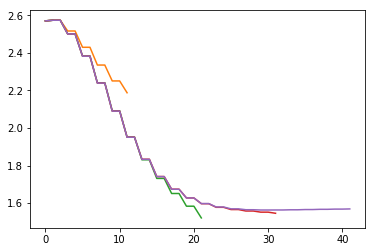

In [185]:
#Deomnstrating the convergence properties in terms of lookahead
for i in range(5):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+1.0,0.1]), iters=105,N=10*i+1)
    plt.plot(np.array(thetas)[:,0])
print(Ks)
print(ass)

at 7 it starts freaking out, needs ore iterations?
90 lookahead transitions to Nan.
Something is overflowing or something is dividing by zero.


Framedelay with measurement noise
larger delay makes effects of noise worse. makes sense.
Using MDP

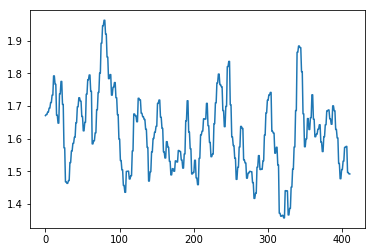

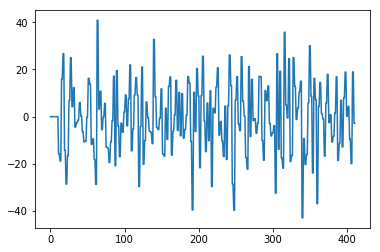

In [222]:
delay = 5
theta = np.array([np.pi/2+0.1, 0.1])
ass=[]
thetas = []
for i in range(delay*2+1):
    thetas.append(theta)
    theta = step(theta, 0, i)
    ass.append(0)
for i in range(200):
    ptheta=thetas[-2*delay-1] + np.random.randn(2)*0.1
    for i in range(2*delay):
        ptheta = step(ptheta ,ass[-2*delay+i],i)
    #print(thetas[-2*delay])
    _, ass1, _, _, = iLQR(ptheta, iters=15,N=30)
    a = ass1[1]
    theta = step(theta, a, 0)
    thetas.append(theta)
    theta = step(theta, a, 1)
    #print(theta)
    ass.append(a)
    ass.append(a)
    thetas.append(theta)
plt.plot(np.array(thetas)[:,0])
plt.figure()
plt.plot(ass)
#print(ass)

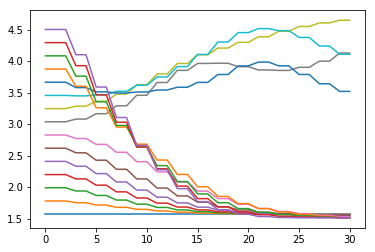

In [12]:
#Deomnstrating the convergence properties in terms of lookahead
for i in range(15):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+np.pi/15 * i,0.0]), iters=15,N=30)
    plt.plot(np.array(thetas)[:,0])
#print(Ks)
#print(ass)

That's kind of curious behavior. There is an area where it doesn't know what to do really but then it comes back. It kind of makes sense.